In [ ]:
%pip install scikit-learn scikit-image numpy matplotlib keras tensorflow

In [118]:
# FEATURE EXTRACTION #

import numpy as np
from skimage import io
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage import img_as_ubyte

def extract_color_features(image):
    # RGB histograms
    nbins = 16
    rh = np.histogram(image[:,:,0].flatten(), nbins, density = True)
    gh = np.histogram(image[:,:,1].flatten(), nbins, density = True)
    bh = np.histogram(image[:,:,2].flatten(), nbins, density = True)

    # Mean and standard deviation of RGB channels
    r_mean = np.mean(image[:,:,0])
    g_mean = np.mean(image[:,:,1])
    b_mean = np.mean(image[:,:,2])
    r_std = np.std(image[:,:,0])
    g_std = np.std(image[:,:,1])
    b_std = np.std(image[:,:,2])

    return np.concatenate((rh[0], gh[0], bh[0], [r_mean, g_mean, b_mean, r_std, g_std, b_std]))

def extract_texture_features(image):
    # Convert to grayscale amd unsigned byte
    gray = img_as_ubyte(rgb2gray(image))

    # Extract texture-related features
    glcm = graycomatrix(gray, [5], [0], 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')
    asm = graycoprops(glcm, 'ASM')

    return np.concatenate((contrast[0], dissimilarity[0], homogeneity[0], energy[0], correlation[0], asm[0]))

# Load images
resized_images_by_biomes = np.load("resized_images_by_biomes.npy", allow_pickle=True).item()

# Extract features
x = []
y = []
for biome, images in resized_images_by_biomes.items():
    for image in images:
        color_features = extract_color_features(image)
        texture_features = extract_texture_features(image)
        x.append(np.concatenate((color_features, texture_features)))
        y.append(biome)

# Convert to numpy arrays
x = np.array(x)
y = np.array(y)

In [5]:
# HELPER METHOD #

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

def train_model(x, y, model):
    # 5-fold cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle = True)

    acc = 0
    recall = np.array([0., 0., 0., 0., 0., 0.])
    precision = np.array([0., 0., 0., 0., 0., 0.])

    for train_index, test_index in kf.split(x, y):
        # Training phase
        x_train = x[train_index, :]
        y_train = y[train_index]
        model.fit(x_train, y_train)

        # Test phase
        x_test = x[test_index, :]
        y_test = y[test_index]    
        y_pred = model.predict(x_test)

        # Calculate confusion matrix and model performance
        cm = confusion_matrix(y_test, y_pred)
        
        acc += (cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5])/len(y_test)    

        recall[0] += cm[0,0]/(cm[0,0] + cm[0,1] + cm[0,2] + cm[0,3] + cm[0,4] + cm[0,5])
        recall[1] += cm[1,1]/(cm[1,0] + cm[1,1] + cm[1,2] + cm[1,3] + cm[1,4] + cm[1,5])
        recall[2] += cm[2,2]/(cm[2,0] + cm[2,1] + cm[2,2] + cm[2,3] + cm[2,4] + cm[2,5])
        recall[3] += cm[3,3]/(cm[3,0] + cm[3,1] + cm[3,2] + cm[3,3] + cm[3,4] + cm[3,5])
        recall[4] += cm[4,4]/(cm[4,0] + cm[4,1] + cm[4,2] + cm[4,3] + cm[4,4] + cm[4,5])
        recall[5] += cm[5,5]/(cm[5,0] + cm[5,1] + cm[5,2] + cm[5,3] + cm[5,4] + cm[5,5])

        precision[0] += cm[0,0]/(cm[0,0] + cm[1,0] + cm[2,0] + cm[3,0] + cm[4,0] + cm[5,0])
        precision[1] += cm[1,1]/(cm[0,1] + cm[1,1] + cm[2,1] + cm[3,1] + cm[4,1] + cm[5,1])
        precision[2] += cm[2,2]/(cm[0,2] + cm[1,2] + cm[2,2] + cm[3,2] + cm[4,2] + cm[5,2])
        precision[3] += cm[3,3]/(cm[0,3] + cm[1,3] + cm[2,3] + cm[3,3] + cm[4,3] + cm[5,3])
        precision[4] += cm[4,4]/(cm[0,4] + cm[1,4] + cm[2,4] + cm[3,4] + cm[4,4] + cm[5,4])
        precision[5] += cm[5,5]/(cm[0,5] + cm[1,5] + cm[2,5] + cm[3,5] + cm[4,5] + cm[5,5])

    # Print results
    print("Model: ", model.__class__.__name__)

    acc = acc/5
    print('Accuracy: ', acc)

    precision = precision/5
    print('Precision: ', precision)

    recall = recall/5
    print('Recall: ', recall)

    print('\n')

In [5]:
# Linear SVM
from sklearn import svm
svm_model = svm.SVC(kernel='linear')
train_model(x, y, svm_model)

Model:  SVC
Accuracy:  0.8487163108370389
Precision:  [0.83091152 0.86418793 0.83120273 0.79676969 0.93577902 0.84511364]
Recall:  [0.88656716 0.84477612 0.94929763 0.74549977 0.88638625 0.78086104]




In [7]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
train_model(x, y, knn_model)

Model:  KNeighborsClassifier
Accuracy:  0.5863032208928088
Precision:  [0.72061178 0.73756628 0.57230004 0.40414717 0.79841433 0.38984911]
Recall:  [0.6358209  0.72537313 0.71132572 0.37127996 0.62247852 0.45353794]




In [8]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
train_model(x, y, dt_model)

Model:  DecisionTreeClassifier
Accuracy:  0.8090288185146057
Precision:  [0.84592127 0.83273288 0.82119828 0.7057243  0.92477707 0.73970084]
Recall:  [0.84179104 0.80298507 0.86308165 0.64066033 0.90099502 0.80379369]




In [9]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100)
train_model(x, y, rf_model)

Model:  RandomForestClassifier
Accuracy:  0.8943456256295604
Precision:  [0.93160675 0.90355409 0.92563097 0.82595039 0.9423993  0.85114742]
Recall:  [0.88955224 0.89552239 0.9046532  0.84147445 0.96404342 0.87144075]




In [ ]:
# Convolutional Neural Network
import numpy as np

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import np_utils

num_classes = 6

# Load images
images_by_biomes = np.load(
    "smaller_resized_images_by_biomes.npy", allow_pickle=True
).item()

# Convert to numpy arrays
x = []
y = []


def map_biome_to_int(biome):
    biome_to_int_dict = {biome: i for i, biome in enumerate(images_by_biomes.keys())}
    return biome_to_int_dict[biome]


for biome, images in images_by_biomes.items():
    for image in images:
        x.append(image)
        y.append(map_biome_to_int(biome))

# Prepare data for CNN
img_rows = x[0].shape[0]
img_cols = x[0].shape[1]

if K.image_data_format() == "channels_first":
    input_shape = (3, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 3)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True)

acc = 0
recall = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
precision = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
k = 0.0
for train_index, test_index in kf.split(x):
    k = k + 1
    print("***** Fold:", k, "*****")

    # Define CNN model
    model = Sequential()
    model.add(
        Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape)
    )
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))

    # Compile model
    model.compile(loss="categorical_crossentropy", optimizer="adam")

    # Fit model
    model.fit(
        np.array(x)[train_index],
        np_utils.to_categorical(np.array(y)[train_index], num_classes),
        epochs=200,
        batch_size=128,
        verbose=1,
    )

    # Evaluate model using test data
    y_test = np.array(y)[test_index]
    y_pred = model.predict(np.array(x)[test_index])
    y_pred_max = np.argmax(y_pred, axis=-1)

    cm = confusion_matrix(y_test, y_pred_max)
    acc += (cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5])/len(y_test)    

    recall[0] += cm[0,0]/(cm[0,0] + cm[0,1] + cm[0,2] + cm[0,3] + cm[0,4] + cm[0,5])
    recall[1] += cm[1,1]/(cm[1,0] + cm[1,1] + cm[1,2] + cm[1,3] + cm[1,4] + cm[1,5])
    recall[2] += cm[2,2]/(cm[2,0] + cm[2,1] + cm[2,2] + cm[2,3] + cm[2,4] + cm[2,5])
    recall[3] += cm[3,3]/(cm[3,0] + cm[3,1] + cm[3,2] + cm[3,3] + cm[3,4] + cm[3,5])
    recall[4] += cm[4,4]/(cm[4,0] + cm[4,1] + cm[4,2] + cm[4,3] + cm[4,4] + cm[4,5])
    recall[5] += cm[5,5]/(cm[5,0] + cm[5,1] + cm[5,2] + cm[5,3] + cm[5,4] + cm[5,5])

    precision[0] += cm[0,0]/(cm[0,0] + cm[1,0] + cm[2,0] + cm[3,0] + cm[4,0] + cm[5,0])
    precision[1] += cm[1,1]/(cm[0,1] + cm[1,1] + cm[2,1] + cm[3,1] + cm[4,1] + cm[5,1])
    precision[2] += cm[2,2]/(cm[0,2] + cm[1,2] + cm[2,2] + cm[3,2] + cm[4,2] + cm[5,2])
    precision[3] += cm[3,3]/(cm[0,3] + cm[1,3] + cm[2,3] + cm[3,3] + cm[4,3] + cm[5,3])
    precision[4] += cm[4,4]/(cm[0,4] + cm[1,4] + cm[2,4] + cm[3,4] + cm[4,4] + cm[5,4])
    precision[5] += cm[5,5]/(cm[0,5] + cm[1,5] + cm[2,5] + cm[3,5] + cm[4,5] + cm[5,5])

    # Save model
    model.save("cnn_model.h5")

    # Print results
    print("Partial reults for {} fold".format(k))
    print("Accuarcy: {}, Recall: {}, Precision: {}".format(acc / k, recall / k, precision / k))

acc /= 5
recall = recall / 5
precision = precision / 5
print("Final results")
print("Accuarcy: {}, Recall: {}, Precision: {}".format(acc, recall, precision))


In [165]:
# CLUSTERING METHODS
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans

from tabulate import tabulate

def plot_data(points, labels, title):   
    fig = plt.figure()
    if points.shape[1] > 2:    
        ax = fig.add_subplot(projection='3d')
        ax.scatter(points[:,0], points[:,1], points[:,2], c=labels, cmap='viridis')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(title)
    else:    
        plt.scatter(points[:,0], points[:,1], c=labels, cmap='viridis')
        plt.xlabel('X')
        plt.ylabel('Y')    
        plt.title(title)

    plt.show()

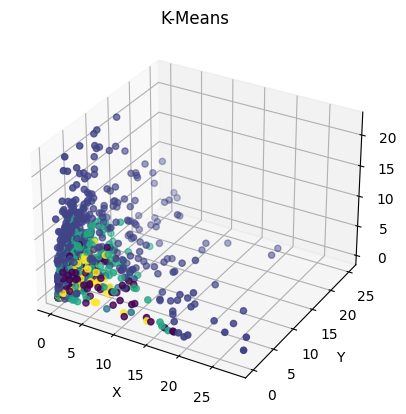

In [155]:
#K Means
kmeans = KMeans(n_clusters=6).fit(x)
kmeans_labels = kmeans.labels_
centers = kmeans.cluster_centers_
plot_data(x, kmeans_labels, 'K-Means')

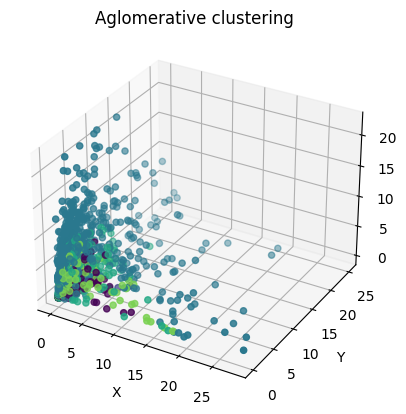

In [182]:
#Aglomerative clustering
agl = AgglomerativeClustering(n_clusters=6).fit(x)
agl_labels = agl.labels_
plot_data(x, agl_labels, 'Aglomerative clustering')

Labels:  [1 1 1 ... 0 3 5]


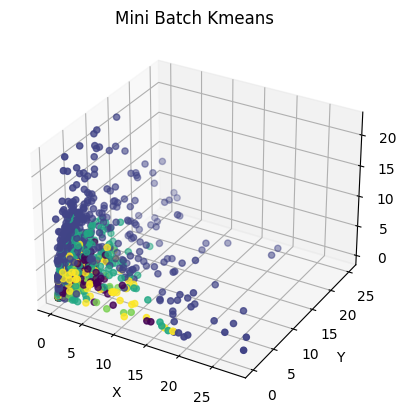

In [168]:
#MiniBatchKMeans
mkmeans = MiniBatchKMeans(n_clusters=6).fit(x)
mkmeans_labels = mkmeans.labels_
print('Labels: ',  mkmeans_labels)
plot_data(x, mkmeans_labels, 'Mini Batch Kmeans')

In [169]:
table = [[biomes] for biomes in y]
for index in range(len(table)):
  table[index].append(kmeans_labels[index])
  table[index].append(agl_labels[index])
  table[index].append(mkmeans_labels[index])
  
print(tabulate(table, headers=["Image","K-means Label","Aglomerative Label","Mini Batch Kmeans Label"]))  

Image       K-means Label    Aglomerative Label    Mini Batch Kmeans Label
--------  ---------------  --------------------  -------------------------
Agua                    1                     2                          1
Agua                    1                     2                          1
Agua                    1                     2                          1
Agua                    1                     2                          1
Agua                    1                     2                          1
Agua                    1                     2                          1
Agua                    1                     2                          1
Agua                    1                     2                          1
Agua                    1                     2                          1
Agua                    1                     2                          1
Agua                    1                     2                          1
Agua                    1